In [1]:
import os
from collections import Counter

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.style.use('seaborn-v0_8-paper')
import seaborn as sns
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

_ = np.seterr(all='ignore')

from utilities import cv_estimate, oversample_multiple_times, getMetrics

Declare constants.

In [2]:
ROOT = '.'
DATA_FOLDER = f'{ROOT}/data' 
OUT_FOLDER = f'{ROOT}/results' 
FILE = f"{DATA_FOLDER}/Supp. File 1.xlsx"
ENDPOINT = 'binaryDILI'

In [3]:
os.makedirs(OUT_FOLDER, exist_ok=True)

# Input data reading

Read labels.

In [4]:
original_data_labels = pd.read_excel(FILE, sheet_name='Original Dataset Labels',
                                     usecols=['InChIKey', 'binaryDILI', 'vDILIConcern'])
additional_data_labels = pd.read_excel(FILE, sheet_name='Additional Set MolDescs',
                                       usecols=['InChIKey', 'binaryDILI', 'vDILIConcern'])
original_data_labels['source'] = 'original'
additional_data_labels['source'] = 'additional'
labels = pd.concat([original_data_labels, additional_data_labels], axis=0)
del original_data_labels, additional_data_labels

Read summarized HCS data.

In [5]:
data_bio = pd.read_excel(FILE, sheet_name='Original Dataset BioDescs')
data_bio = data_bio[data_bio.loc[:,"Inclusion"] == "Included"].drop(['Name', 'SMILES', 'Inclusion'], axis=1)

Read molecular descriptors.

In [6]:
data_chem = pd.read_excel(FILE, sheet_name='Original Dataset MolDescs')
ECFP6 = data_chem['ECFP_6'].str.extractall('(.)')[0].unstack().astype(int)
ECFP6 = ECFP6.rename_axis(index=None, columns=None).rename(columns=lambda x: f'ECFP_6_{x+1}')

data_chem = data_chem.drop(['SMILES', 'ECFP_6'], axis=1)
data_chem = pd.concat([data_chem, ECFP6], axis=1)

Combine data.

In [7]:
full_set_bio = labels.merge(data_bio, on='InChIKey').drop(['InChIKey', 'source'], axis=1).dropna()
full_set_bio_Y = full_set_bio[[ENDPOINT]].values.ravel()
full_set_bio_X = full_set_bio.drop(['vDILIConcern', 'binaryDILI'], axis=1)
full_set_chem = labels.merge(data_chem, on='InChIKey').drop(['InChIKey', 'source'], axis=1).dropna()
full_set_chem_Y = full_set_chem[[ENDPOINT]].values.ravel()
full_set_chem_X = full_set_chem.drop(['vDILIConcern', 'binaryDILI'], axis=1)
full_set_biochem = labels.merge(data_bio, on='InChIKey').merge(data_chem, on='InChIKey').drop(['InChIKey', 'source'], axis=1).dropna()
full_set_biochem_Y = full_set_biochem[[ENDPOINT]].values.ravel()
full_set_biochem_X = full_set_biochem.drop(['vDILIConcern', 'binaryDILI'], axis=1)

Isolate features per cell line reporter.

In [8]:
hmox_bio = full_set_bio_X.loc[:, full_set_bio_X.columns.str.startswith('hmox1_')]
srxn_bio = full_set_bio_X.loc[:, full_set_bio_X.columns.str.startswith('srxn1_')]
chop_bio = full_set_bio_X.loc[:, full_set_bio_X.columns.str.startswith('chop_')]
bip_bio = full_set_bio_X.loc[:, full_set_bio_X.columns.str.startswith('bip_')]
p21_bio = full_set_bio_X.loc[:, full_set_bio_X.columns.str.startswith('p21_')]
btg2_bio = full_set_bio_X.loc[:, full_set_bio_X.columns.str.startswith('btg2_')]
hspa1b_bio = full_set_bio_X.loc[:, full_set_bio_X.columns.str.startswith('hspa1b_')]
icam_bio = full_set_bio_X.loc[:, full_set_bio_X.columns.str.startswith('icam1_')]

# Modelling reporters individually

Model each reporter individually (Supp. Figure 2A).

In [9]:
counts = Counter(full_set_biochem_Y)
minority_counts = min(counts.values())
majority_counts = max(counts.values())

cv_scores_per_reporter_bio = []
for dataset in tqdm([hmox_bio, srxn_bio, chop_bio, bip_bio, p21_bio, btg2_bio, hspa1b_bio, icam_bio]):
    cv_scores_per_reporter_bio.append(pd.DataFrame.from_dict(cv_estimate(XGBClassifier(random_state=42), continuous=False,
                                      X_train=dataset, y_train=full_set_bio_Y,
                                      n_splits=10, stratify=True, shuffle=True, random_state=42)).assign(reporter=dataset.columns.str.split('_').str[0].unique()[0].upper()))

cv_scores_per_reporter_bio = (pd.concat(cv_scores_per_reporter_bio)
                                .drop(['0:1', 'F1', 'AUC 0'], axis=1)
                                .rename(columns={'AUC 1': 'AUC',
                                                 'Acc' : 'Accuracy',
                                                 'BAcc' : 'Balanced Accuracy', 
                                                 'Sen' : 'Sensitivity',
                                                 'Spe' : 'Specificity'}))
cv_scores_per_reporter_bio = pd.melt(cv_scores_per_reporter_bio, id_vars=['reporter'])

  0%|          | 0/8 [00:00<?, ?it/s]

Combined with molecular descriptors (Supp. Figure 2B).

In [10]:
cv_scores_per_reporter_biochem = []
for dataset in tqdm([hmox_bio, srxn_bio, chop_bio, bip_bio, p21_bio, btg2_bio, hspa1b_bio, icam_bio]):
    cv_scores_per_reporter_biochem.append(pd.DataFrame.from_dict(cv_estimate(XGBClassifier(random_state=42),
                                                                             continuous=False,
                                                                             X_train=pd.concat((dataset, full_set_biochem_X.iloc[:, -2084:]), axis=1),
                                                                             y_train=full_set_bio_Y,
                                                                             n_splits=10,
                                                                             stratify=True,
                                                                             shuffle=True,
                                                                             random_state=42)
                                                                 ).assign(reporter=(dataset.columns
                                                                                    .str.split('_')
                                                                                    .str[0]
                                                                                    .unique()[0]
                                                                                    .upper())))



cv_scores_per_reporter_biochem = (pd.concat(cv_scores_per_reporter_biochem)
                                .drop(['0:1', 'F1', 'AUC 0'], axis=1)
                                .rename(columns={'AUC 1': 'AUC',
                                                 'Acc' : 'Accuracy',
                                                 'BAcc' : 'Balanced Accuracy', 
                                                 'Sen' : 'Sensitivity',
                                                 'Spe' : 'Specificity'}))
cv_scores_per_reporter_biochem = pd.melt(cv_scores_per_reporter_biochem, id_vars=['reporter'])

  0%|          | 0/8 [00:00<?, ?it/s]

Plot.

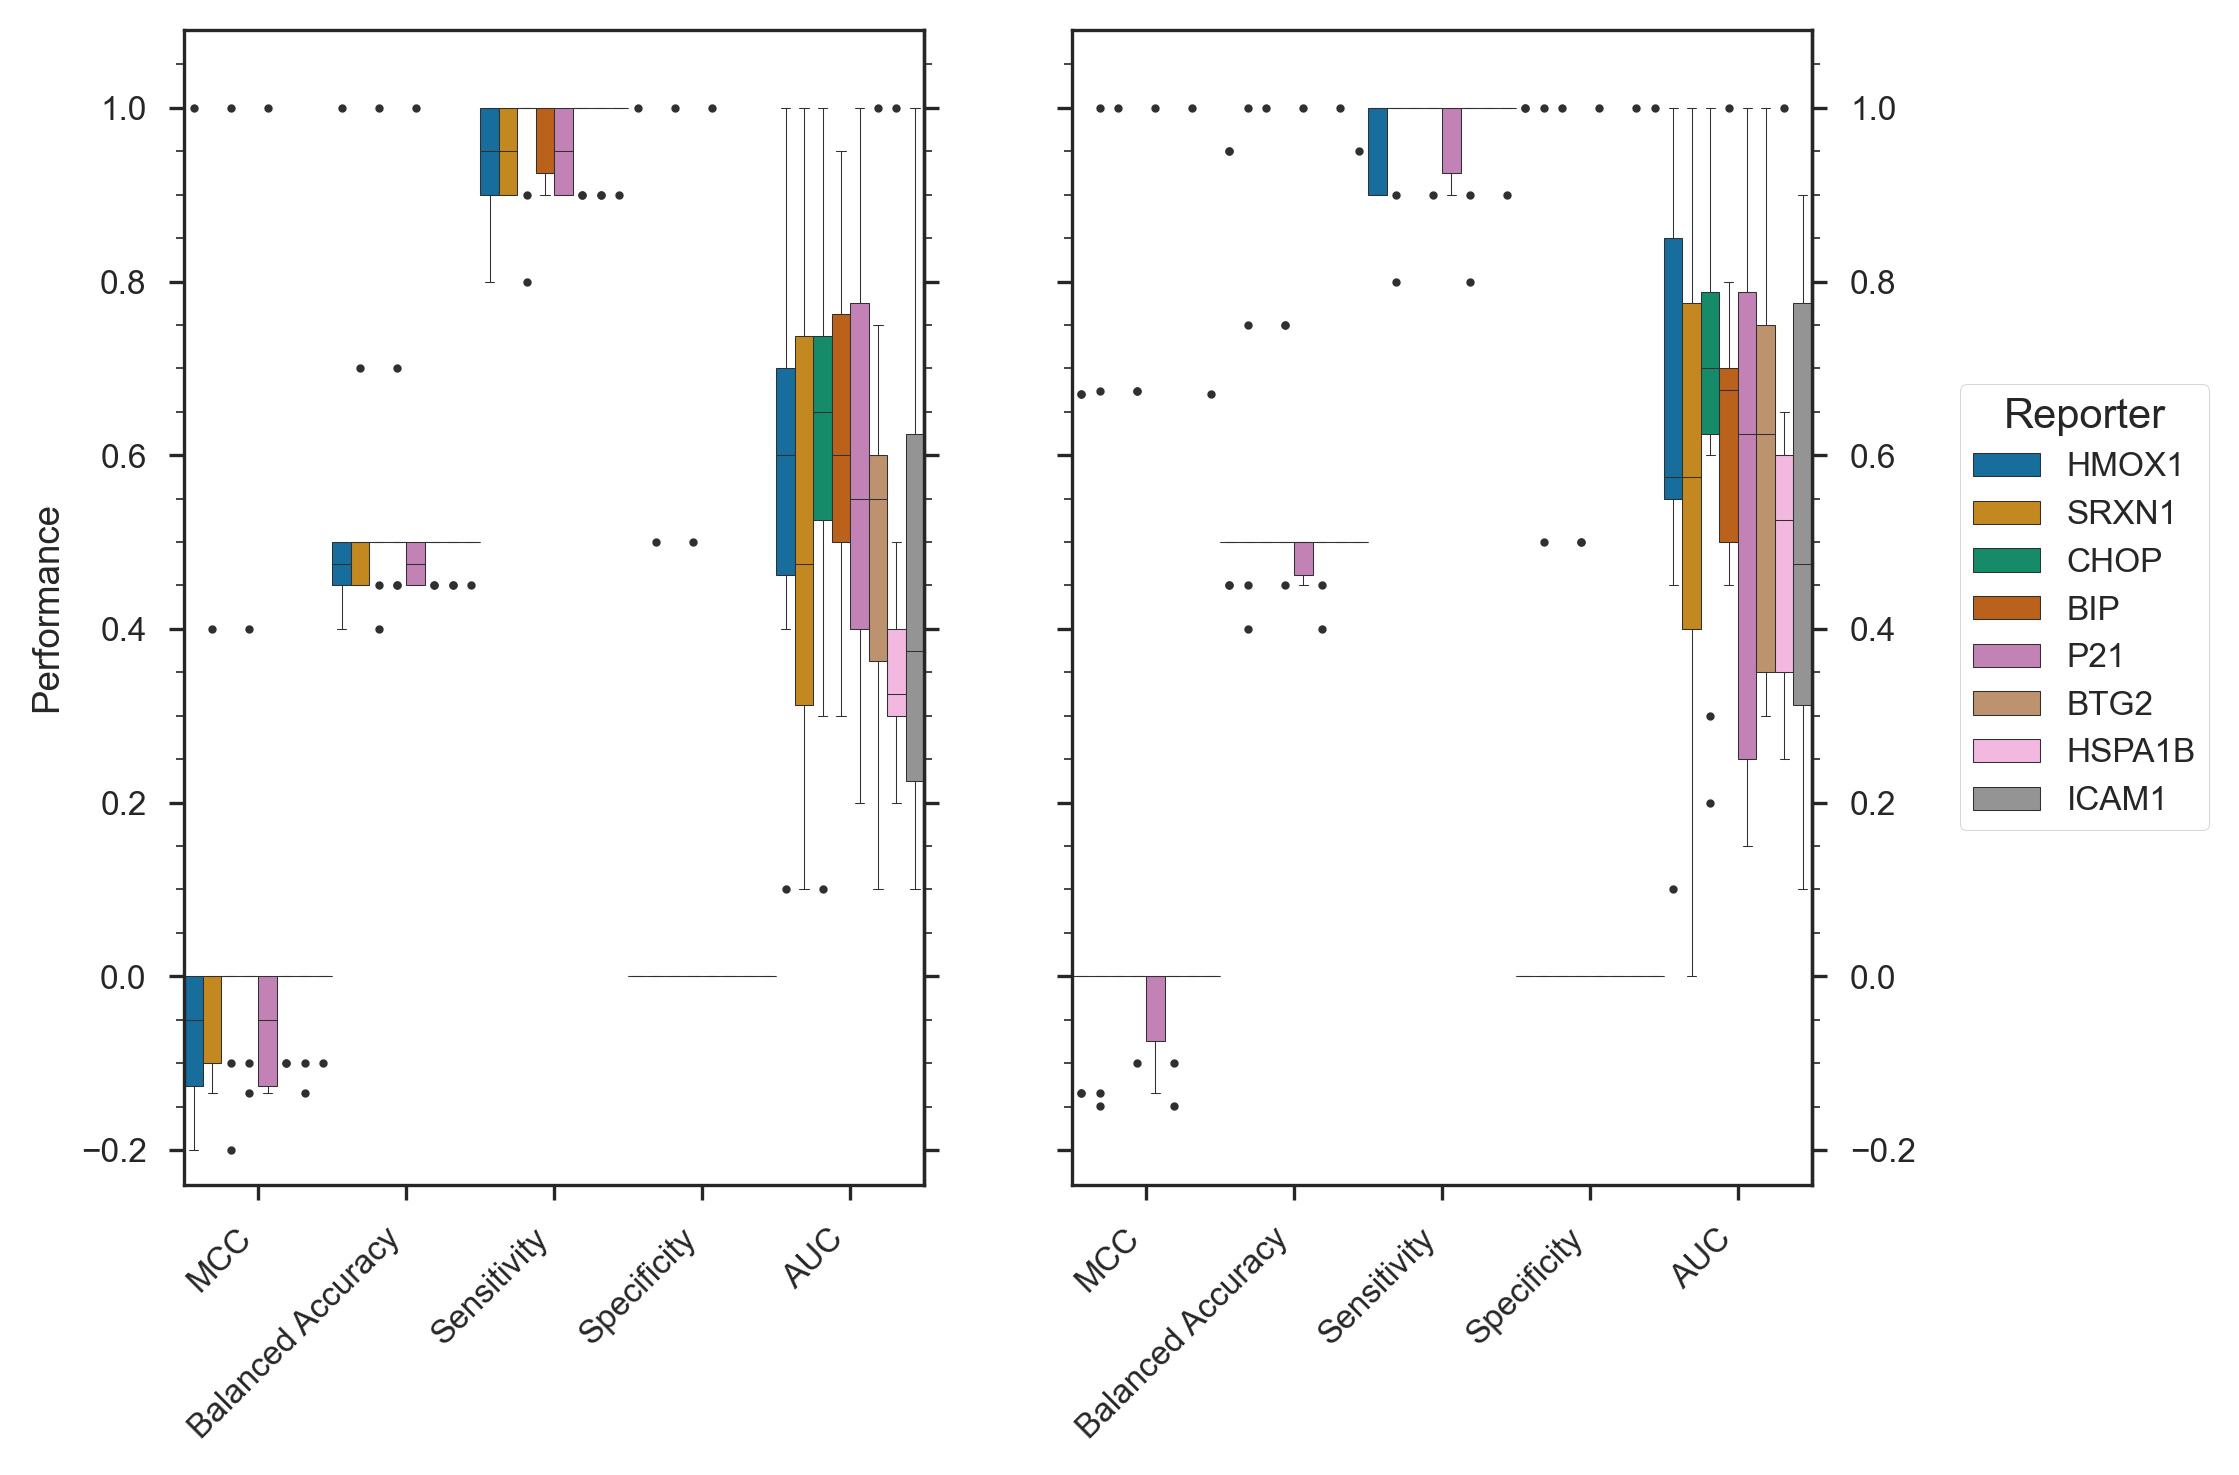

In [11]:
with sns.axes_style('white', rc={'xtick.bottom': True, 'ytick.left': True, 'font.size': 22},):
    interest_values = ['MCC', 'Balanced Accuracy', 'Sensitivity', 'Specificity', 'AUC']
    sns.set_palette("colorblind")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,5), dpi=300, sharey=True)
    ax1 = axes[0]
    sns.boxplot(x="variable", y="value", hue="reporter",
                data=cv_scores_per_reporter_bio[cv_scores_per_reporter_bio.variable.isin(interest_values)], 
                width=1.0,
                ax=ax1,
                legend=False,
                linewidth=0.25,
                flierprops=dict(markersize=1))
    secaxy = ax1.secondary_yaxis('right')
    ax1.set(xlabel='', ylabel='Performance')
    ax1.set_ylim(-0.24, 1.09)
    ax1.set_xticklabels(ax1.get_xticklabels(), ha='right', rotation=45)
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    secaxy.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    secaxy.yaxis.set_ticklabels([])
    # Second plot
    ax2 = axes[1]
    sns.boxplot(x="variable", y="value", hue="reporter",
                data=cv_scores_per_reporter_biochem[cv_scores_per_reporter_biochem.variable.isin(interest_values)], 
                width=1.0,
                ax=ax2,
                legend=True,
                linewidth=0.25,
                flierprops=dict(markersize=1))
    secaxy = ax2.secondary_yaxis('right')
    ax2.set(xlabel='', ylabel='')
    ax2.set_ylim(-0.24, 1.09)
    ax2.set_xticklabels(ax2.get_xticklabels(), ha='right', rotation=45)
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    secaxy.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax2.legend(bbox_to_anchor=(1.2, 0.5), loc='center left', borderaxespad=0., title='Reporter')
    fig.show()

SMOTE on each of the dataset (Supp. Figure 3A and 3B).

In [12]:
cv_scores_per_reporter_bio_smote_balanced = []
for dataset in tqdm([hmox_bio, srxn_bio, chop_bio, bip_bio, p21_bio, btg2_bio, hspa1b_bio, icam_bio]):
    cv_scores_per_reporter_bio_smote_balanced.append(oversample_multiple_times(times=100,
                                                                               dataset_X=dataset,
                                                                               dataset_Y=full_set_bio_Y,
                                                                               model=XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.3,
                                                                                                   colsample_bytree=0.7, colsample_bylevel=0.7,
                                                                                                   colsample_bynode=0.7),
                                                                               splits=5,
                                                                               continuous=False,
                                                                               stratify=True,
                                                                               shuffle=True,
                                                                               random_state=42,
                                                                               leave_pbar=False)
                                                         .assign(reporter=(dataset.columns
                                                                                  .str.split('_')
                                                                                  .str[0]
                                                                                  .unique()[0]
                                                                                  .upper())))

cv_scores_per_reporter_bio_smote_balanced = (pd.concat(cv_scores_per_reporter_bio_smote_balanced)
                                               .drop(['model', '0:1', 'F1', 'AUC 0'], axis=1)
                                               .rename(columns={'AUC 1': 'AUC',
                                                                'Acc' : 'Accuracy',
                                                                'BAcc' : 'Balanced Accuracy', 
                                                                'Sen' : 'Sensitivity',
                                                                'Spe' : 'Specificity'}))
cv_scores_per_reporter_bio_smote_balanced = pd.melt(cv_scores_per_reporter_bio_smote_balanced, id_vars=['reporter'])

cv_scores_per_reporter_biochem_smote_balanced = []
for dataset in tqdm([hmox_bio, srxn_bio, chop_bio, bip_bio, p21_bio, btg2_bio, hspa1b_bio, icam_bio]):
    cv_scores_per_reporter_biochem_smote_balanced.append(oversample_multiple_times(times=100,
                                                                                   dataset_X=pd.concat((dataset, full_set_biochem_X.iloc[:, -2084:]), axis=1),
                                                                                   dataset_Y=full_set_bio_Y,
                                                                                   model=XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.3,
                                                                                                       colsample_bytree=0.7, colsample_bylevel=0.7,
                                                                                                       colsample_bynode=0.7),
                                                                                   splits=5,
                                                                                   continuous=False,
                                                                                   stratify=True,
                                                                                   shuffle=True,
                                                                                   random_state=42,
                                                                                   leave_pbar=False)
                                                             .assign(reporter=(dataset.columns
                                                                                      .str[0]
                                                                                      .unique()[0]
                                                                                      .upper())))

cv_scores_per_reporter_biochem_smote_balanced = (pd.concat(cv_scores_per_reporter_biochem_smote_balanced)
                                               .drop(['model', '0:1', 'F1', 'AUC 0'], axis=1)
                                               .rename(columns={'AUC 1': 'AUC',
                                                                'Acc' : 'Accuracy',
                                                                'BAcc' : 'Balanced Accuracy', 
                                                                'Sen' : 'Sensitivity',
                                                                'Spe' : 'Specificity'}))
cv_scores_per_reporter_biochem_smote_balanced = pd.melt(cv_scores_per_reporter_biochem_smote_balanced, id_vars=['reporter'])

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Plot.

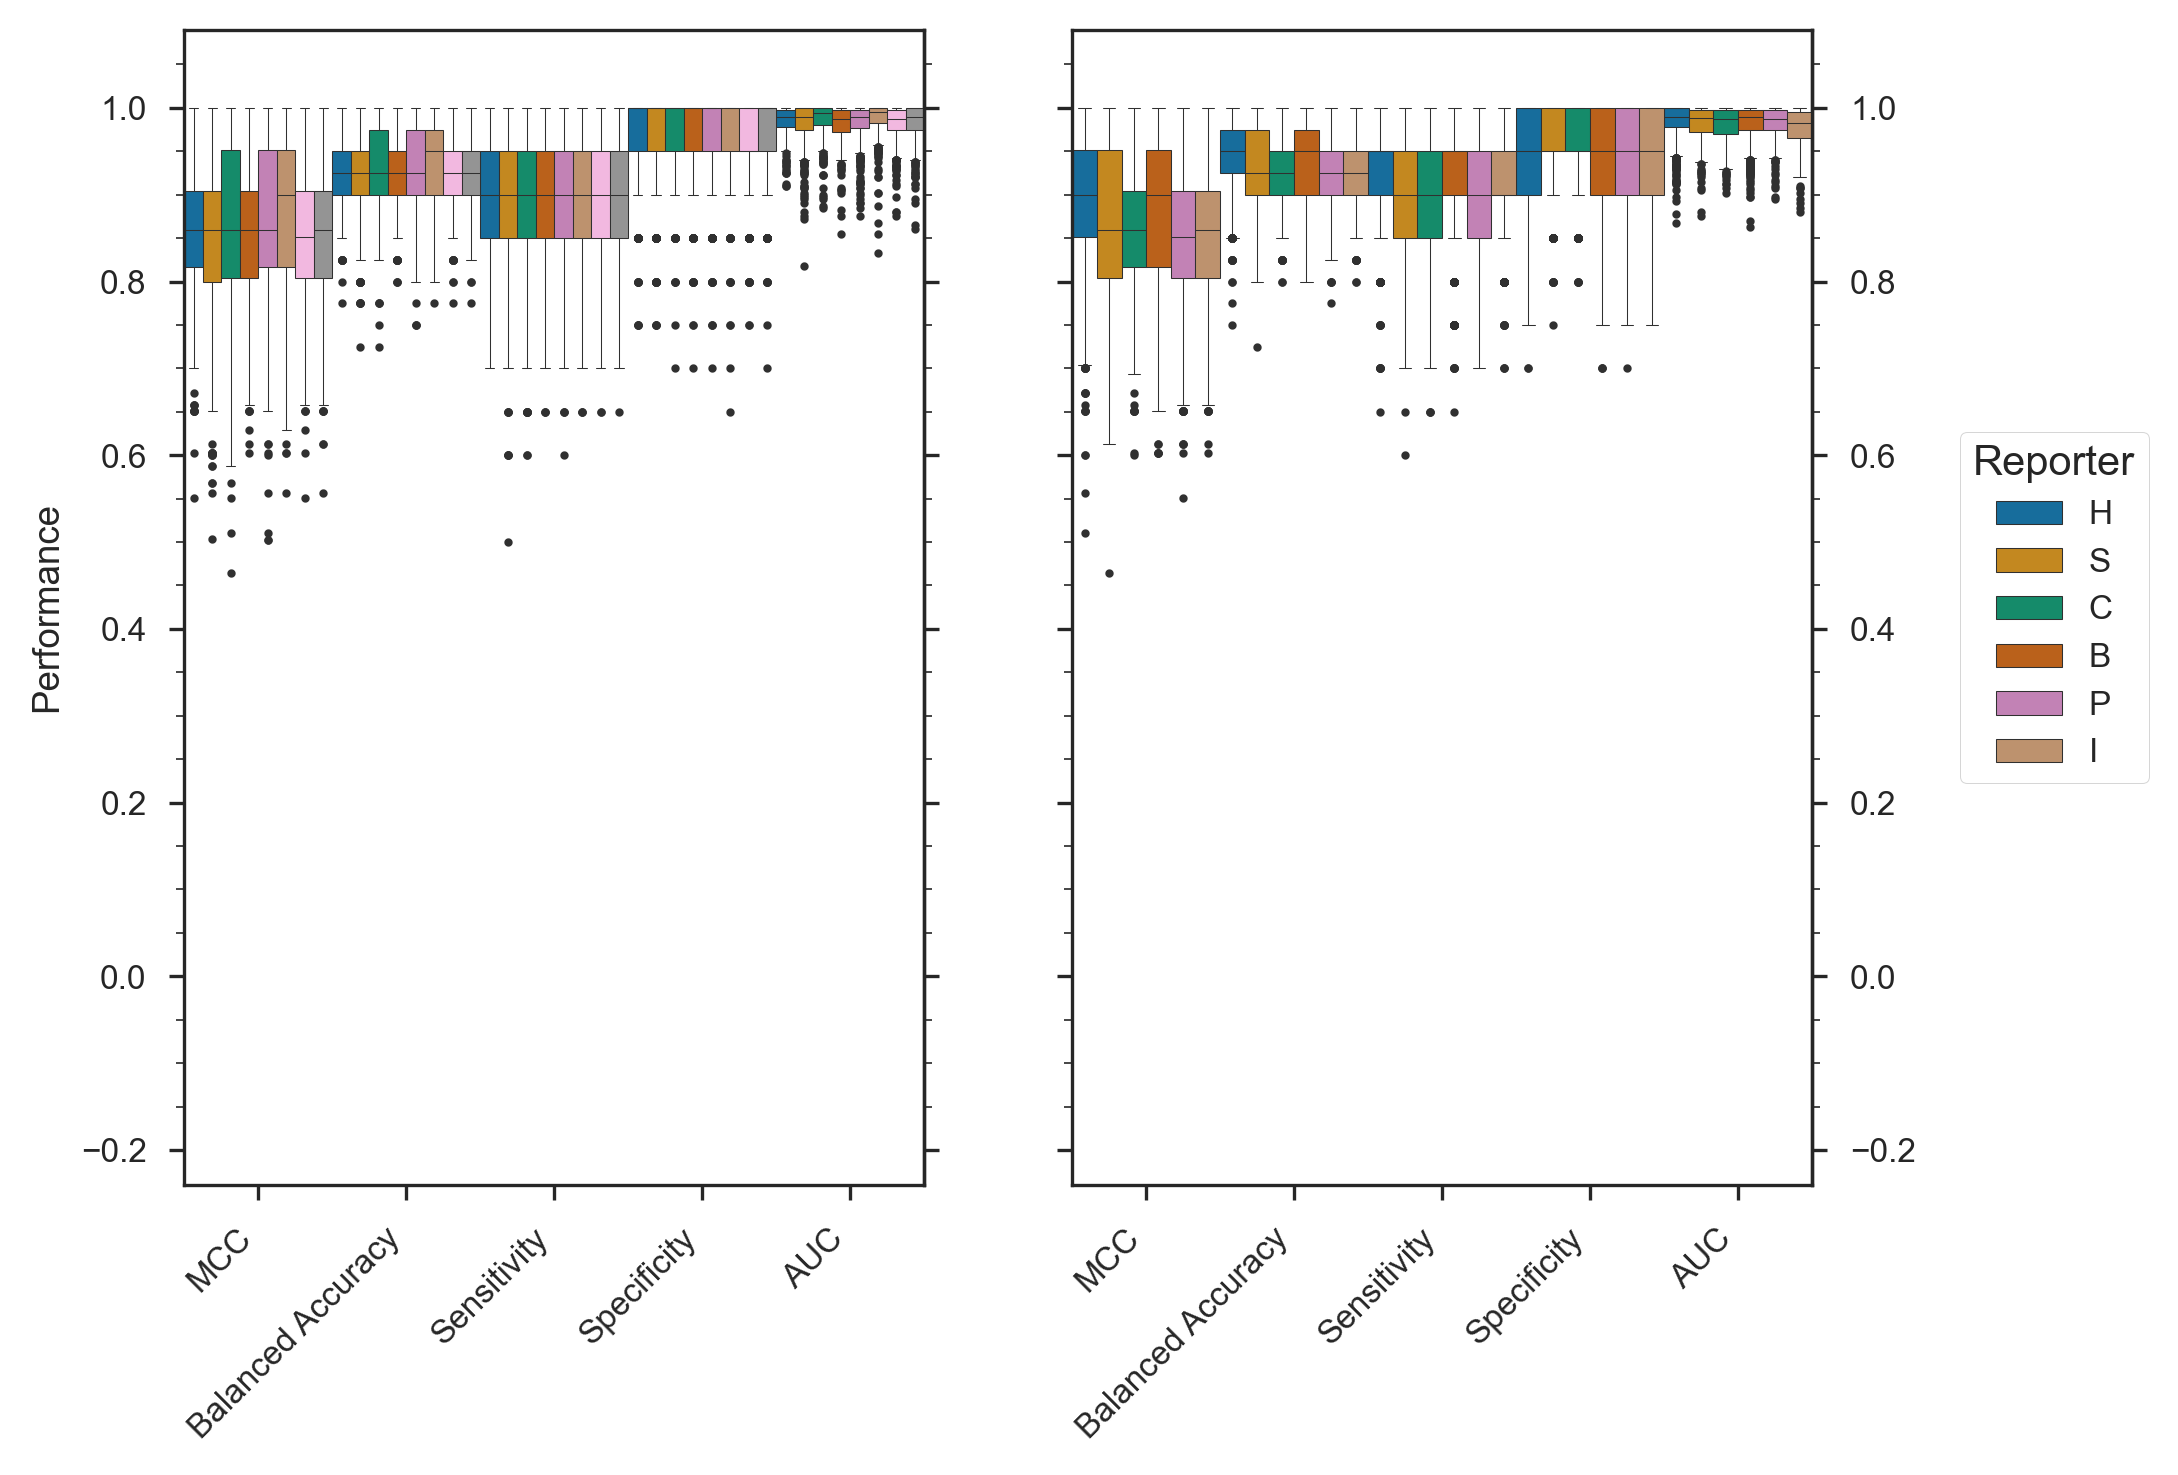

In [13]:
with sns.axes_style('white', rc={'xtick.bottom': True, 'ytick.left': True, 'font.size': 22},):
    interest_values = ['MCC', 'Balanced Accuracy', 'Sensitivity', 'Specificity', 'AUC']
    sns.set_palette("colorblind")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,5), dpi=300, sharey=True)
    ax1 = axes[0]
    sns.boxplot(x="variable", y="value", hue="reporter",
                data=cv_scores_per_reporter_bio_smote_balanced[cv_scores_per_reporter_bio_smote_balanced.variable.isin(interest_values)], 
                width=1.0,
                ax=ax1,
                legend=False,
                linewidth=0.25,
                flierprops=dict(markersize=1))
    secaxy = ax1.secondary_yaxis('right')
    ax1.set(xlabel='', ylabel='Performance')
    ax1.set_ylim(-0.24, 1.09)
    ax1.set_xticklabels(ax1.get_xticklabels(), ha='right', rotation=45)
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    secaxy.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    secaxy.yaxis.set_ticklabels([])
    # Second plot
    ax2 = axes[1]
    sns.boxplot(x="variable", y="value", hue="reporter",
                data=cv_scores_per_reporter_biochem_smote_balanced[cv_scores_per_reporter_biochem_smote_balanced.variable.isin(interest_values)], 
                width=1.0,
                ax=ax2,
                legend=True,
                linewidth=0.25,
                flierprops=dict(markersize=1))
    secaxy = ax2.secondary_yaxis('right')
    ax2.set(xlabel='', ylabel='')
    ax2.set_ylim(-0.24, 1.09)
    ax2.set_xticklabels(ax2.get_xticklabels(), ha='right', rotation=45)
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    secaxy.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax2.legend(bbox_to_anchor=(1.2, 0.5), loc='center left', borderaxespad=0., title='Reporter')
    fig.show()

Save metrics to file.

In [14]:
cv_scores_per_reporter_bio.to_csv(f'{OUT_FOLDER}/cv_scores_per_reporter_bio.tsv', sep='\t', index=False)
cv_scores_per_reporter_bio_smote_balanced.to_csv(f'{OUT_FOLDER}/cv_scores_per_reporter_bio_smote_balanced.tsv', sep='\t', index=False)
cv_scores_per_reporter_biochem.to_csv(f'{OUT_FOLDER}/cv_scores_per_reporter_biochem.tsv', sep='\t', index=False)
cv_scores_per_reporter_biochem_smote_balanced.to_csv(f'{OUT_FOLDER}/cv_scores_per_reporter_biochem_smote_balanced.tsv', sep='\t', index=False)

# Modelling combined reporters

Combine reporters (Supp. Figure 4A).

In [15]:
classifier_bio = XGBClassifier(n_estimators=100, #max_depth=7, learning_rate=0.3, 
                               colsample_bytree=0.1,
                               # colsample_bylevel=0.7, 
                               #colsample_bynode=0.7,
                               scale_pos_weight=minority_counts/majority_counts,
                               random_state=1234)
classifier_chem = XGBClassifier(n_estimators=100, #max_depth=7, learning_rate=0.3, 
                                colsample_bytree=0.1,
                                # colsample_bylevel=0.7, 
                                #colsample_bynode=0.7,
                                scale_pos_weight=minority_counts/majority_counts,
                               random_state=1234)
classifier_biochem = XGBClassifier(n_estimators=100, #max_depth=7, learning_rate=0.3, 
                                   colsample_bytree=0.1,
                                   # colsample_bylevel=0.7, 
                                   #colsample_bynode=0.7,
                                   scale_pos_weight=minority_counts/majority_counts,
                               random_state=1234)

cv_scores_bio = pd.DataFrame.from_dict(
                    cv_estimate(classifier_bio, continuous=False,
                        X_train=full_set_bio_X, y_train=full_set_bio_Y,
                        n_splits=10, stratify=True, shuffle=True, random_state=42))
cv_scores_chem = pd.DataFrame.from_dict(
                    cv_estimate(classifier_chem, continuous=False,
                             X_train=full_set_chem_X, y_train=full_set_chem_Y,
                             n_splits=10, stratify=True, shuffle=True, random_state=42))
cv_scores_biochem = pd.DataFrame.from_dict(
                        cv_estimate(classifier_biochem, continuous=False,
                             X_train=full_set_biochem_X, y_train=full_set_biochem_Y,
                             n_splits=10, stratify=True, shuffle=True, random_state=42))

all_cv_scores = pd.concat([cv_scores_bio.assign(Descriptors='Biological'), 
                           cv_scores_chem.assign(Descriptors='Physicochemical'),
                           cv_scores_biochem.assign(Descriptors='Both')]
                         ).drop(['0:1', 'F1', 'AUC 0'], axis=1
                         ).rename(columns={'AUC 1': 'AUC',
                                           'Acc' : 'Accuracy',
                                           'BAcc' : 'Balanced Accuracy', 
                                           'Sen' : 'Sensitivity',
                                           'Spe' : 'Specificity'})
all_cv_scores = pd.melt(all_cv_scores, id_vars=['Descriptors'])
all_cv_scores.to_csv(f'{OUT_FOLDER}/all_cv_scores.tsv', sep='\t', index=False)

Use SMOTE on combined reporters (Supp. Figure 4B).

In [16]:
cv_scores_bio_smote_balanced = oversample_multiple_times(100, full_set_bio_X, full_set_bio_Y,
                                                   XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.3,
                                                                 colsample_bytree=0.7, colsample_bylevel=0.7, colsample_bynode=0.7),
                                                   5, False, True, True, 42)
cv_scores_chem_smote_balanced = oversample_multiple_times(100, full_set_chem_X, full_set_chem_Y,
                                                   XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.3,
                                                                 colsample_bytree=0.7, colsample_bylevel=0.7, colsample_bynode=0.7),
                                                   5, False, True, True, 42)
cv_scores_biochem_smote_balanced = oversample_multiple_times(100, full_set_biochem_X, full_set_biochem_Y,
                                                   XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.3,
                                                                 colsample_bytree=0.7, colsample_bylevel=0.7, colsample_bynode=0.7),
                                                   5, False, True, True, 42)

all_balanced_cv_scores = pd.concat([cv_scores_bio_smote_balanced.assign(Descriptors='Biological'), 
                                    cv_scores_chem_smote_balanced.assign(Descriptors='Physicochemical'),
                                    cv_scores_biochem_smote_balanced.assign(Descriptors='Both')]
                                  ).drop(['model', '0:1', 'F1', 'AUC 0'], axis=1
                                  ).rename(columns={'AUC 1': 'AUC',
                                                    'Acc' : 'Accuracy',
                                                    'BAcc' : 'Balanced Accuracy', 
                                                    'Sen' : 'Sensitivity',
                                                    'Spe' : 'Specificity'})
all_balanced_cv_scores = pd.melt(all_balanced_cv_scores, id_vars=['Descriptors'])
all_balanced_cv_scores.to_csv(f'{OUT_FOLDER}/all_balanced_cv_scores.tsv', sep='\t', index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Plot.

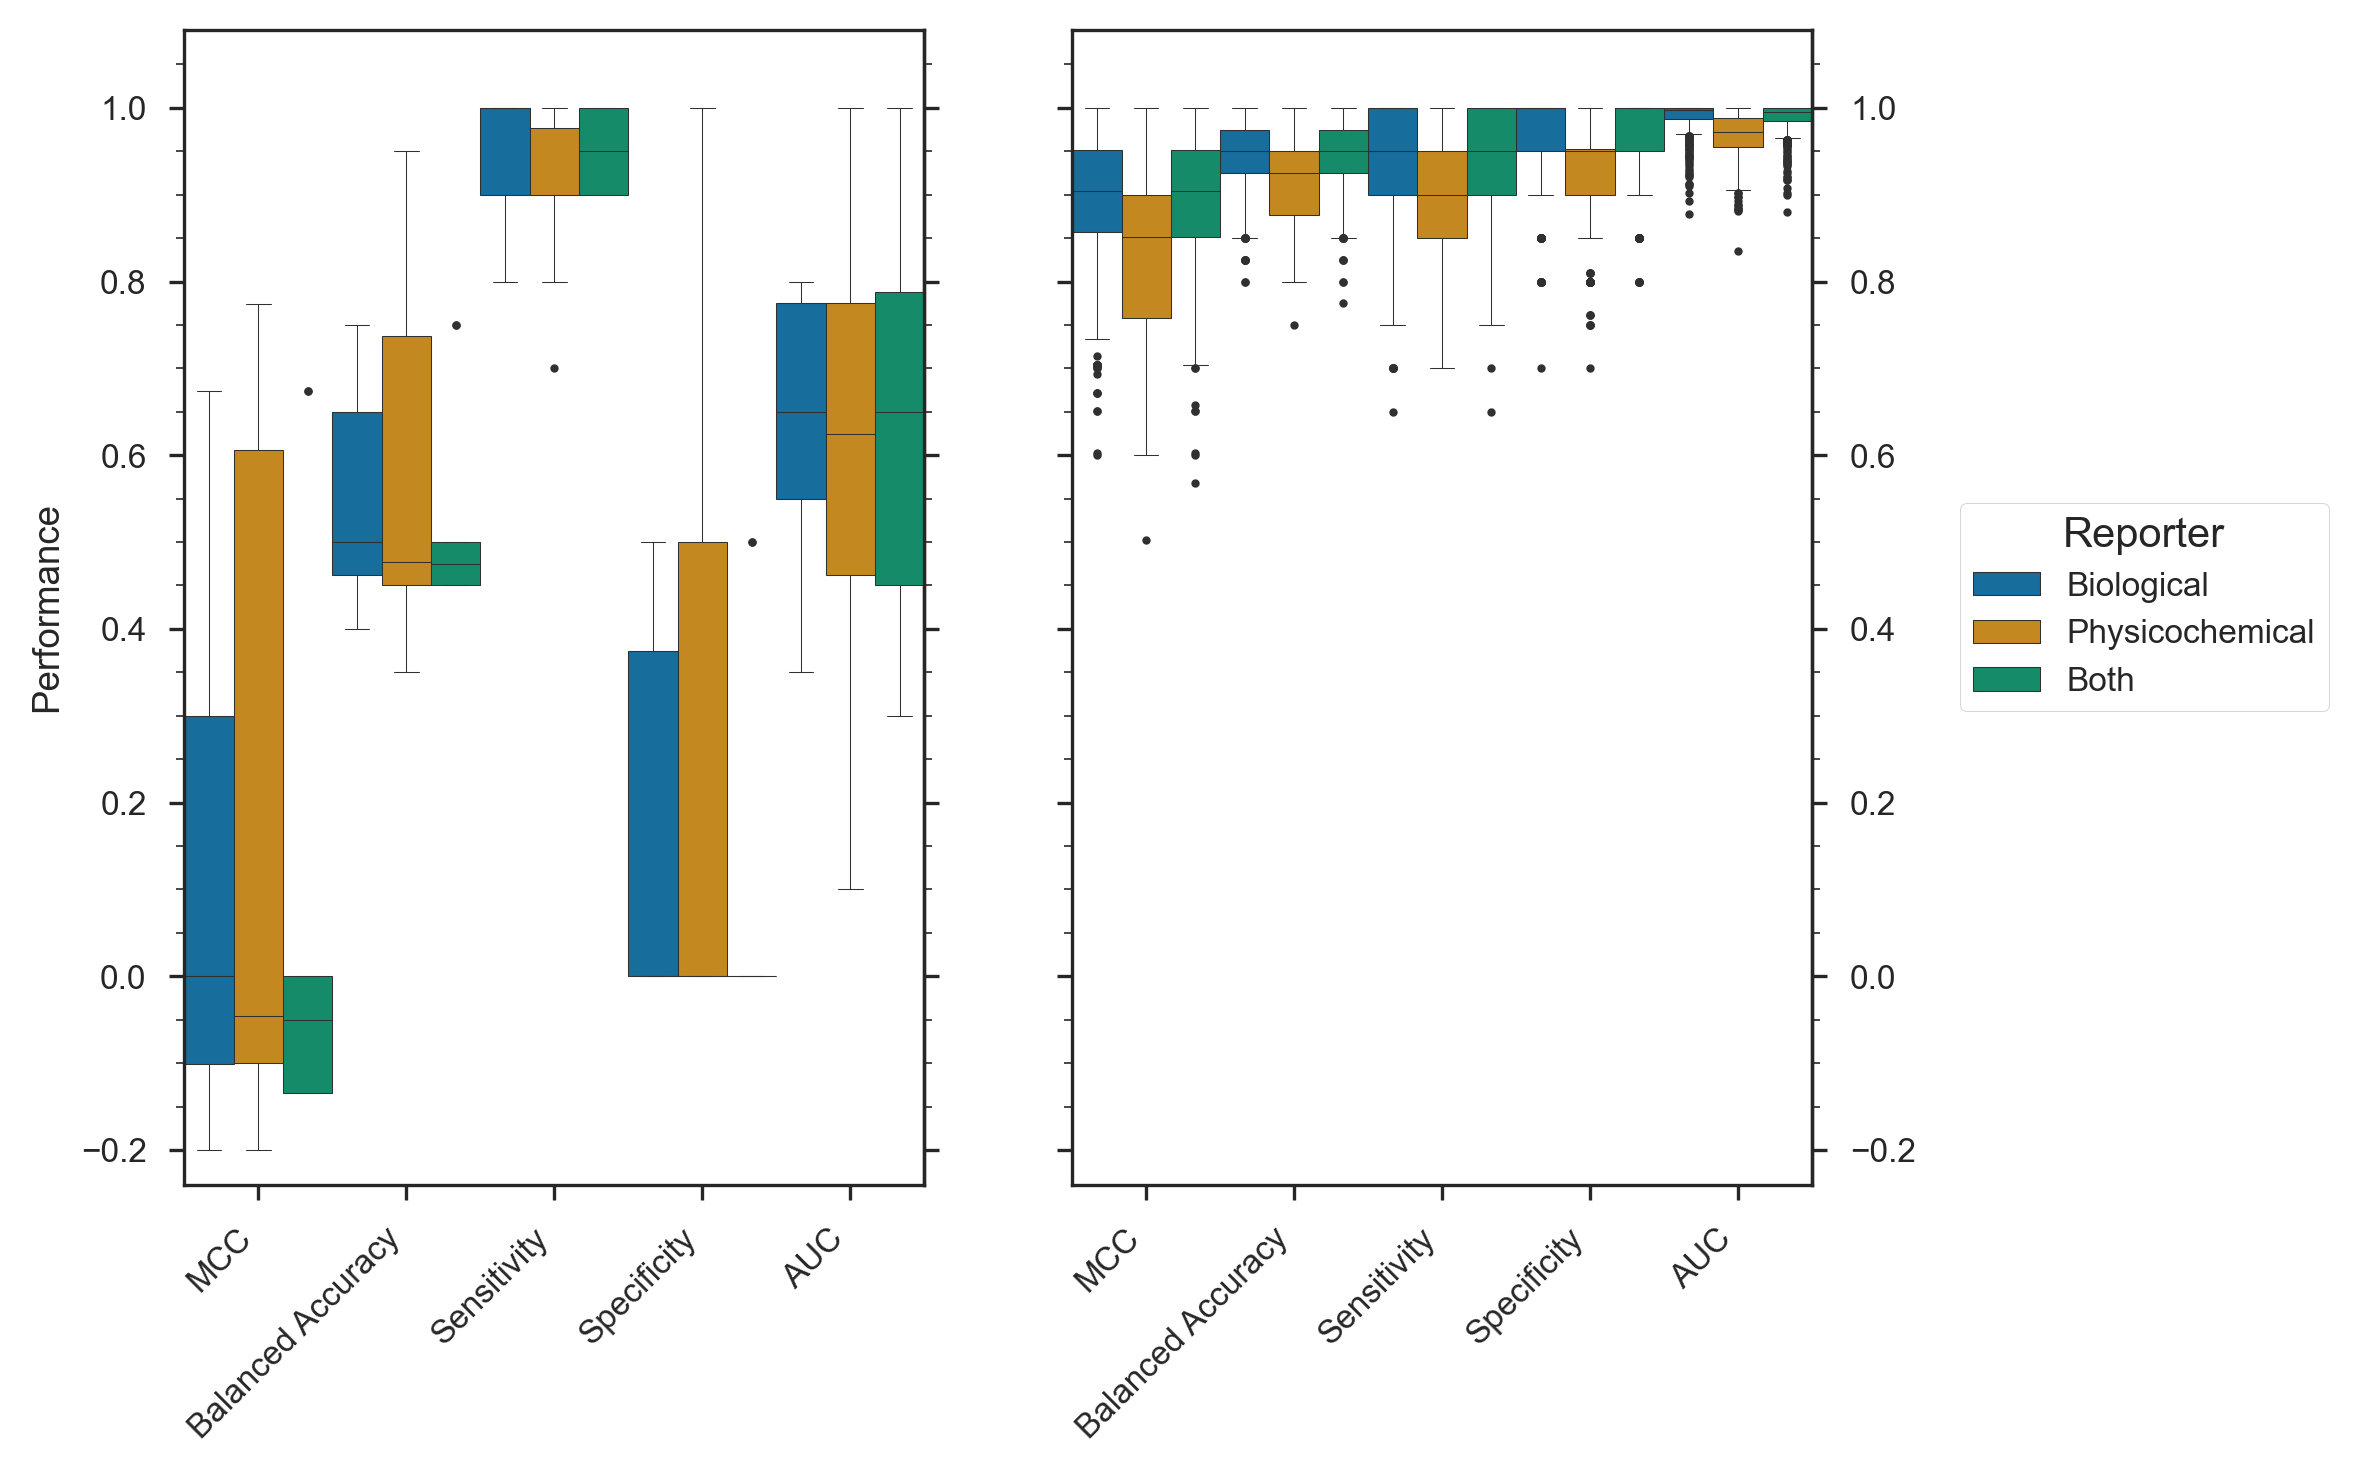

In [17]:
with sns.axes_style('white', rc={'xtick.bottom': True, 'ytick.left': True, 'font.size': 22},):
    interest_values = ['MCC', 'Balanced Accuracy', 'Sensitivity', 'Specificity', 'AUC']
    sns.set_palette("colorblind")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,5), dpi=300, sharey=True)
    ax1 = axes[0]
    sns.boxplot(x="variable", y="value", hue="Descriptors",
                data=all_cv_scores[all_cv_scores.variable.isin(interest_values)], 
                width=1.0,
                ax=ax1,
                legend=False,
                linewidth=0.25,
                flierprops=dict(markersize=1))
    secaxy = ax1.secondary_yaxis('right')
    ax1.set(xlabel='', ylabel='Performance')
    ax1.set_ylim(-0.24, 1.09)
    ax1.set_xticklabels(ax1.get_xticklabels(), ha='right', rotation=45)
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    secaxy.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    secaxy.yaxis.set_ticklabels([])
    # Second plot
    ax2 = axes[1]
    sns.boxplot(x="variable", y="value", hue="Descriptors",
                data=all_balanced_cv_scores[all_balanced_cv_scores.variable.isin(interest_values)], 
                width=1.0,
                ax=ax2,
                legend=True,
                linewidth=0.25,
                flierprops=dict(markersize=1))
    secaxy = ax2.secondary_yaxis('right')
    ax2.set(xlabel='', ylabel='')
    ax2.set_ylim(-0.24, 1.09)
    ax2.set_xticklabels(ax2.get_xticklabels(), ha='right', rotation=45)
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    secaxy.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax2.legend(bbox_to_anchor=(1.2, 0.5), loc='center left', borderaxespad=0., title='Reporter')
    fig.show()

Test SMOTE models on the set of additional molecules from the DILIRank dataset, not used in the training set.
1) Load the additional data

In [18]:
comp_data = pd.read_excel(FILE, sheet_name='Additional Set MolDescs',
                          usecols=['binaryDILI', 'vDILIConcern', 'ALogP',
                                   'Molecular_Weight', 'Molecular_Solubility', 'H_Count', 'C_Count',
                                   'N_Count', 'O_Count', 'F_Count', 'S_Count', 'Cl_Count',
                                   'Num_H_Acceptors_Lipinski', 'Num_H_Donors_Lipinski', 'JY', 'Wiener',
                                   'CHI_V_3_P', 'CHI_V_3_C', 'ES_Sum_sCH3', 'ES_Sum_ssCH2', 'ES_Sum_dsCH',
                                   'ES_Sum_aaCH', 'ES_Sum_sssCH', 'ES_Sum_dssC', 'ES_Sum_aasC',
                                   'ES_Sum_aaaC', 'ES_Sum_ssssC', 'ES_Sum_sNH2', 'ES_Sum_ssNH',
                                   'ES_Sum_aaN', 'ES_Sum_sssN', 'ES_Sum_ddsN', 'ES_Sum_sOH', 'ES_Sum_dO',
                                   'ES_Sum_ssO', 'ES_Sum_ssS', 'Kappa_3_AM', 'PHI', 'ECFP_6'])
ECFP6 = comp_data['ECFP_6'].str.extractall('(.)')[0].unstack().astype(int)
ECFP6 = ECFP6.rename_axis(index=None, columns=None).rename(columns=lambda x: f'ECFP_6_{x+1}')

comp_data = comp_data.drop(['ECFP_6'], axis=1)
comp_data = pd.concat([comp_data, ECFP6], axis=1)
test_data = pd.read_excel(FILE, sheet_name='Test cmps MolDescs',
                          usecols=['binaryDILI', 'vDILIConcern', 'ALogP',
                                   'Molecular_Weight', 'Molecular_Solubility', 'H_Count', 'C_Count',
                                   'N_Count', 'O_Count', 'F_Count', 'S_Count', 'Cl_Count',
                                   'Num_H_Acceptors_Lipinski', 'Num_H_Donors_Lipinski', 'JY', 'Wiener',
                                   'CHI_V_3_P', 'CHI_V_3_C', 'ES_Sum_sCH3', 'ES_Sum_ssCH2', 'ES_Sum_dsCH',
                                   'ES_Sum_aaCH', 'ES_Sum_sssCH', 'ES_Sum_dssC', 'ES_Sum_aasC',
                                   'ES_Sum_aaaC', 'ES_Sum_ssssC', 'ES_Sum_sNH2', 'ES_Sum_ssNH',
                                   'ES_Sum_aaN', 'ES_Sum_sssN', 'ES_Sum_ddsN', 'ES_Sum_sOH', 'ES_Sum_dO',
                                   'ES_Sum_ssO', 'ES_Sum_ssS', 'Kappa_3_AM', 'PHI', 'ECFP_6'])
ECFP6 = test_data['ECFP_6'].str.extractall('(.)')[0].unstack().astype(int)
ECFP6 = ECFP6.rename_axis(index=None, columns=None).rename(columns=lambda x: f'ECFP_6_{x+1}')

test_data = test_data.drop(['ECFP_6'], axis=1)
test_data = pd.concat([test_data, ECFP6], axis=1)

test_chem = pd.concat([comp_data, test_data], axis=0)
test_chem_Y = test_chem[[ENDPOINT]].values.ravel()
test_chem_X = test_chem.drop(['vDILIConcern', 'binaryDILI'], axis=1)

2) Make predictions using the model solely based on chemistry (we do not have biological data for these molecules).

In [19]:
pred_test = getMetrics(classifier_chem, test_chem_Y, test_chem_X, False)
pred_test_balanced = [getMetrics(classifier, test_chem_Y, test_chem_X, False) for classifier in tqdm(cv_scores_chem_smote_balanced['model'])]
pred_test_balanced_res = pd.DataFrame.from_dict(pred_test_balanced).drop(['0:1', 'F1', 'AUC 0'], axis=1
                                            ).rename(columns={'AUC 1': 'AUC',
                                                              'Acc' : 'Accuracy',
                                                              'BAcc' : 'Balanced Accuracy', 
                                                              'Sen' : 'Sensitivity',
                                                              'Spe' : 'Specificity'})
pred_test_res = pd.DataFrame.from_dict([pred_test]).drop(['0:1', 'F1', 'AUC 0'], axis=1
                                            ).rename(columns={'AUC 1': 'AUC',
                                                              'Acc' : 'Accuracy',
                                                              'BAcc' : 'Balanced Accuracy', 
                                                              'Sen' : 'Sensitivity',
                                                              'Spe' : 'Specificity'})
pred_test_res_melt = pd.melt(pred_test_res)
pred_test_balanced_res_melt = pd.melt(pred_test_balanced_res)

pred_test_res_melt.to_csv(f'{OUT_FOLDER}/pred_test_res_melt.tsv', sep='\t', index=False)
pred_test_balanced_res_melt.to_csv(f'{OUT_FOLDER}/pred_test_balanced_res_melt.tsv', sep='\t', index=False)

pred_concat = pd.concat((pred_test_res_melt.assign(balanced='No oversampling'),
                         pred_test_balanced_res_melt.assign(balanced='SMOTE')))

  0%|          | 0/500 [00:00<?, ?it/s]

Plot.

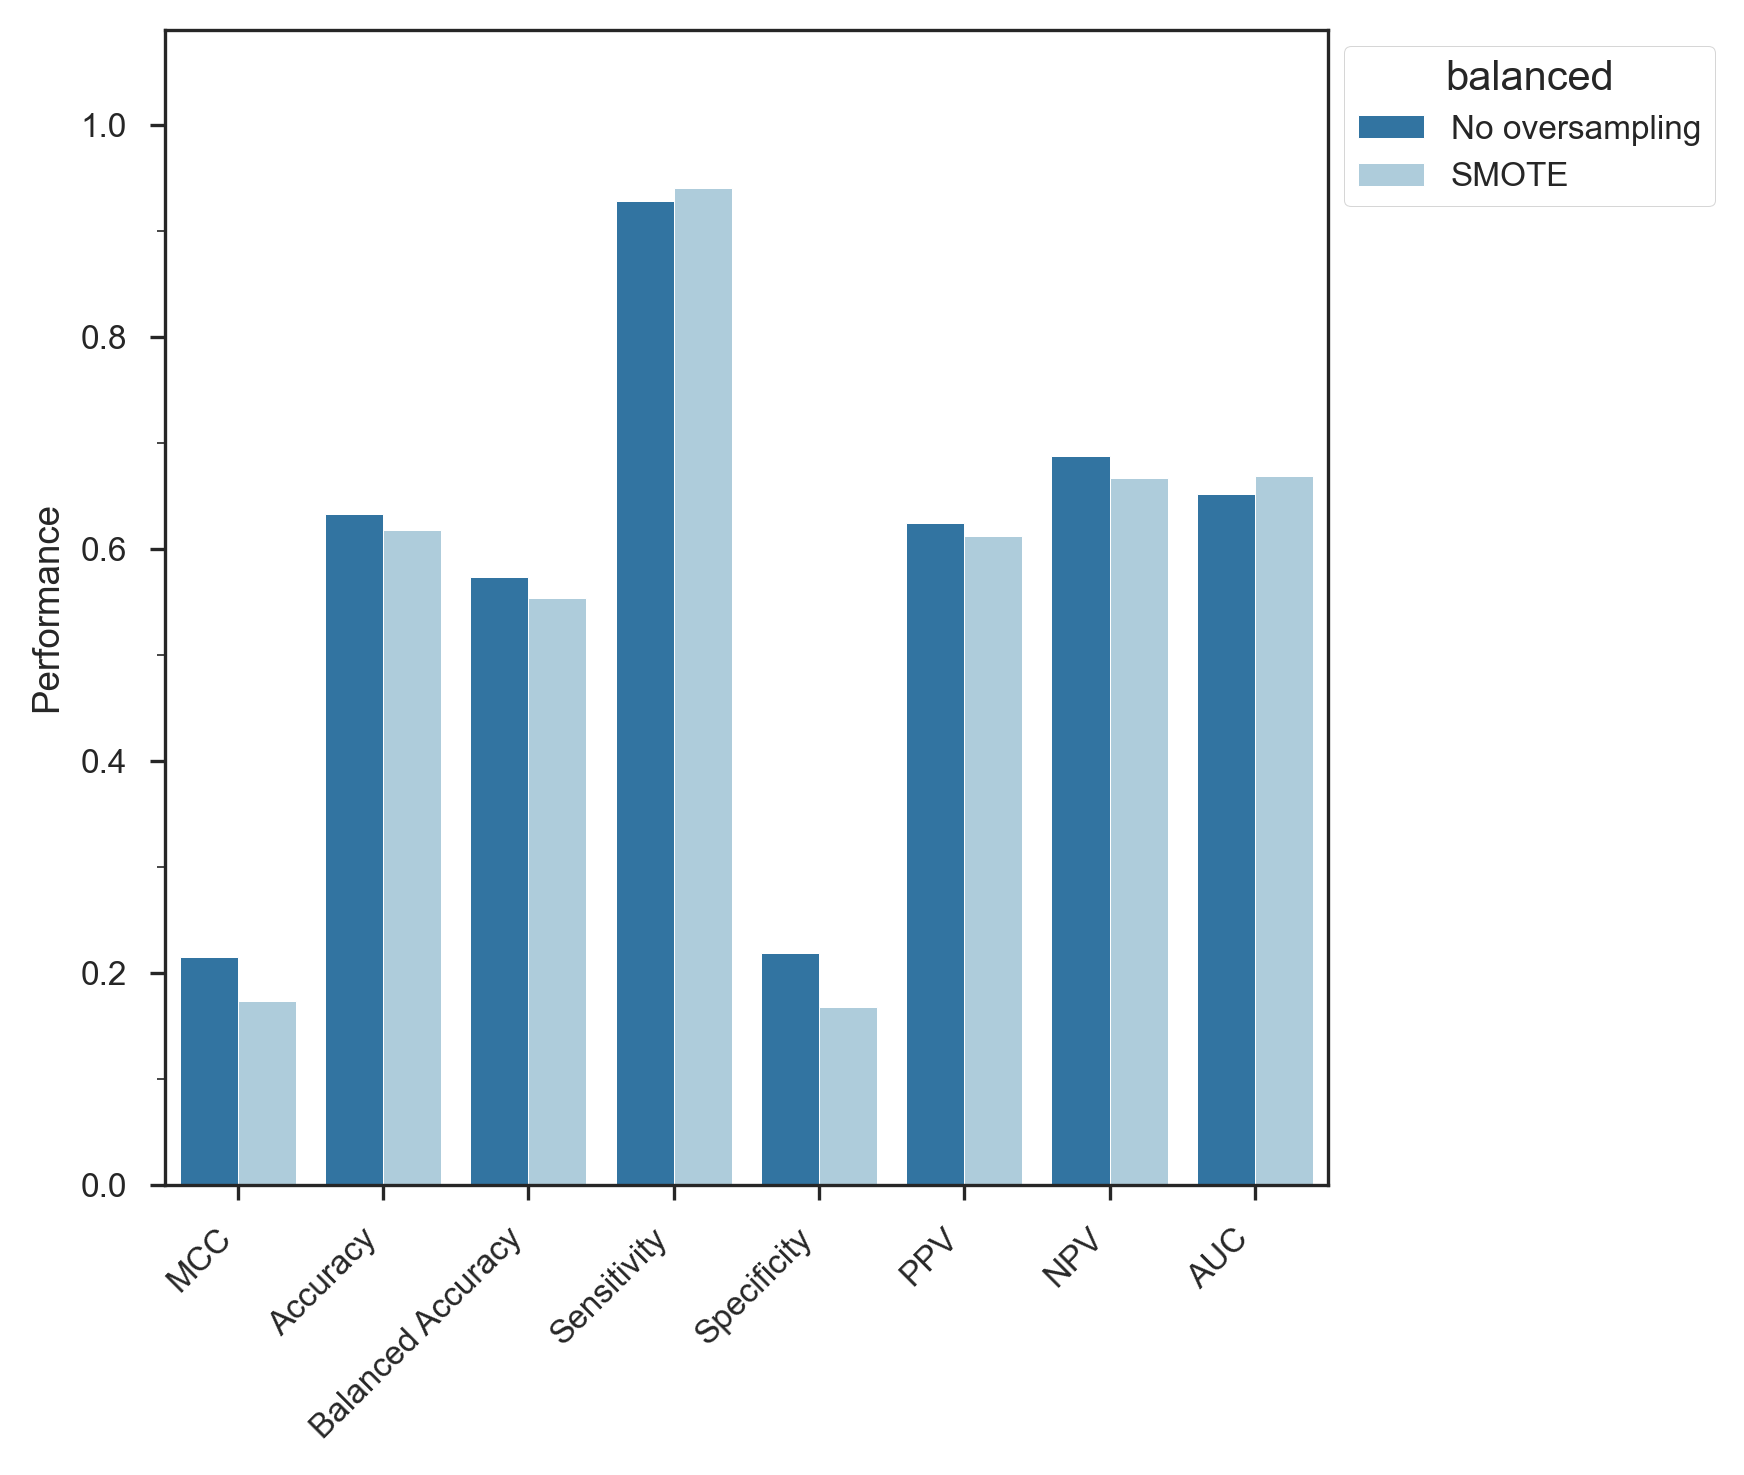

In [20]:
with sns.axes_style('white', rc={'xtick.bottom': True, 'ytick.left': True, 'font.size': 22},):
    sns.set_palette("colorblind")
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax1 = fig.subplots(1, 1, sharey=True)
    sns.barplot(x='variable',y='value',data=pred_concat, hue='balanced', palette=[sns.color_palette("Paired")[1], sns.color_palette("Paired")[0]],
                ax=ax1)
    ax1.set(xlabel='', ylabel='Performance', title='')
    ax1.set_xticklabels(ax1.get_xticklabels(), ha='right', rotation=45)
    ax1.set_ylim(0.0, 1.09)
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
    fig.show()